<a href="https://colab.research.google.com/github/Radityaz/2025_ComputerVision_TI2B/blob/main/Jobsheet03_RikoAdityaZaki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JOBSHEET 03 : TEKNIK REGRESI GAMBAR

## Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

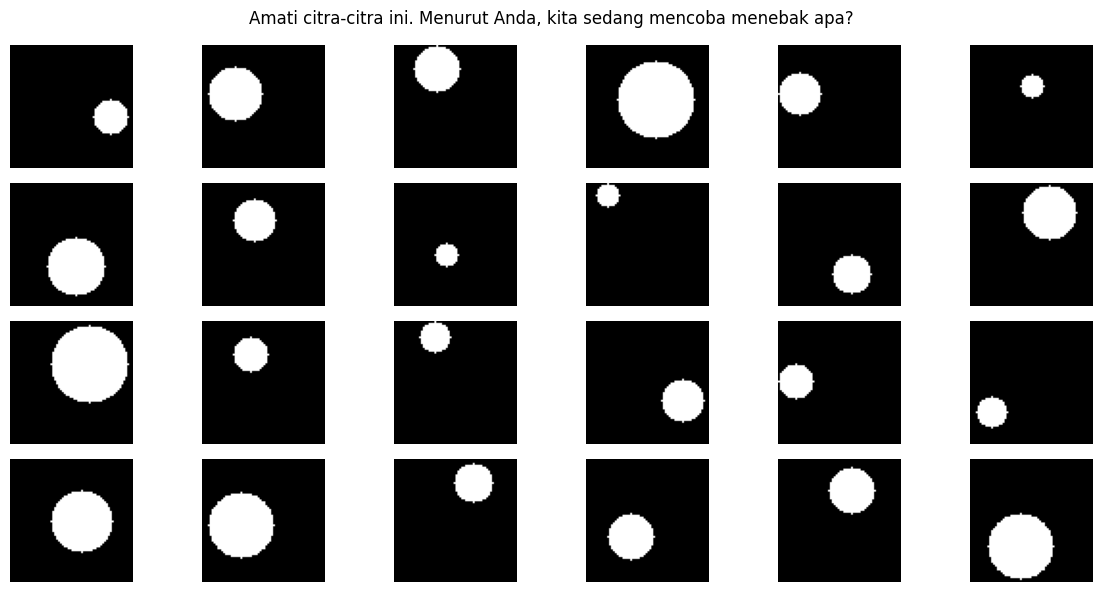

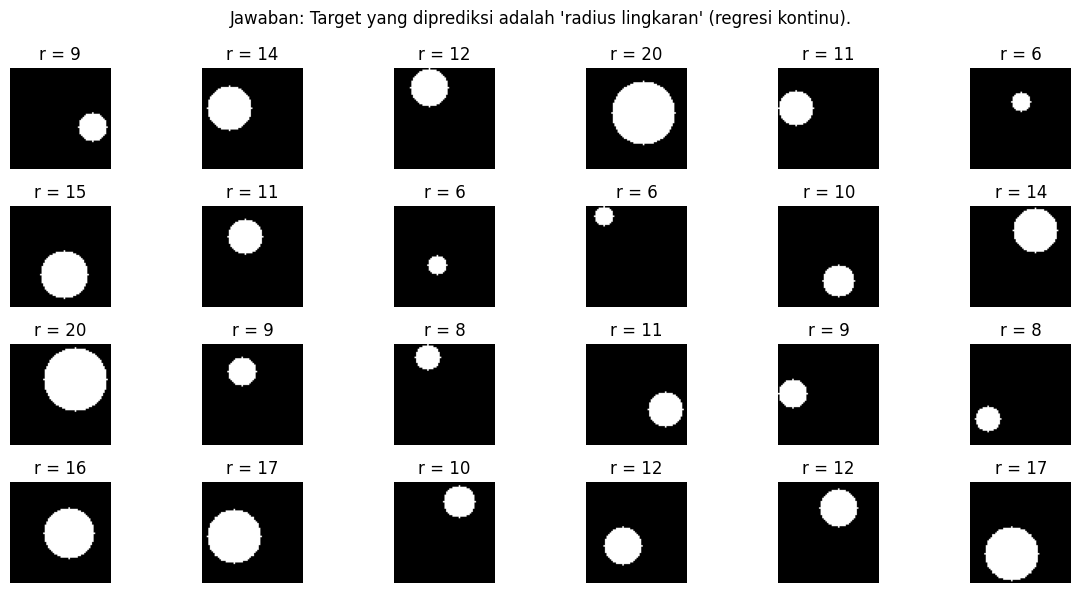

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
MAE=0.996 | RMSE=1.202 | R²=0.933


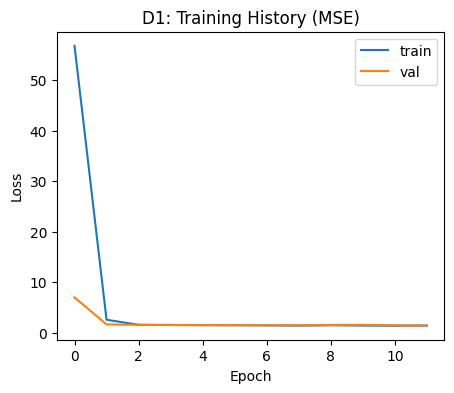

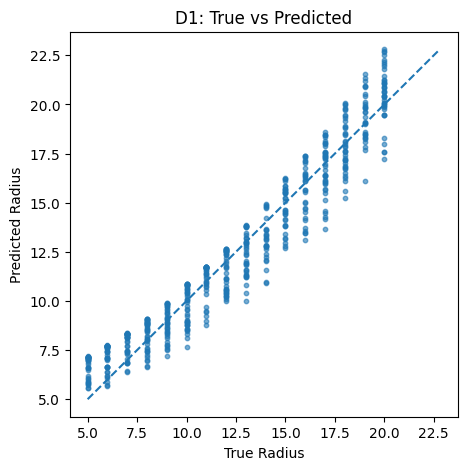

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1) # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r) # center-x
    cy = np.random.randint(r, img_size - r) # center-y
    cv2.circle(img, (cx, cy), r, (255.), -1) # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)
    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)

# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r = {int(rads[i])}")
    plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()

# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # output regresi
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
    epochs=12, batch_size=64, verbose=0)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

## Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace)

In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("✅ Kaggle API siap digunakan.")
else:
  print("kaggle.json belum ditemukan. Upload terlebih dahulu.")
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

✅ Kaggle API siap digunakan.
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


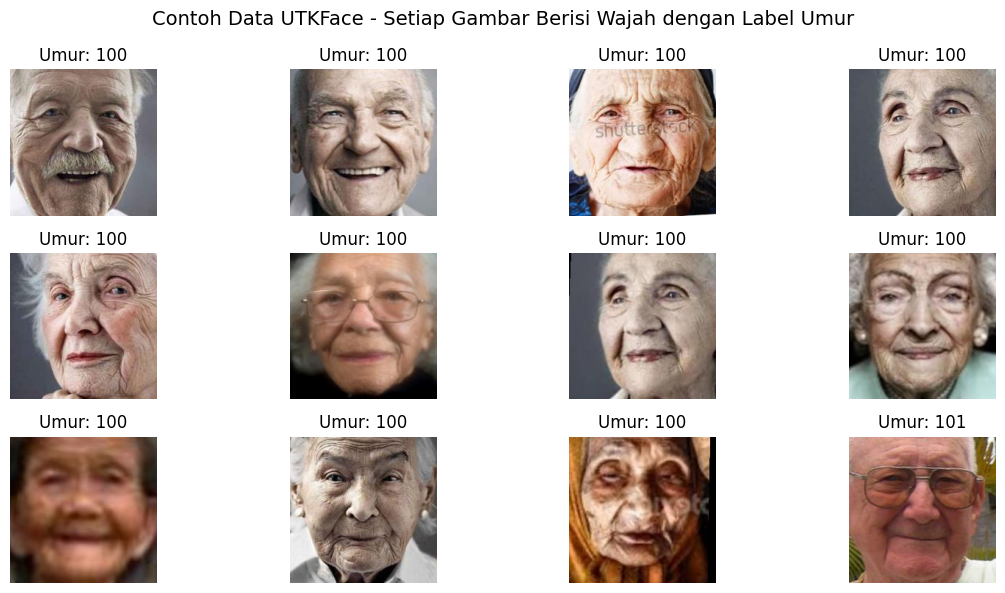

☑ Dataset siap dilatih.
Hardware: GPU


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 69s 175ms/step - loss: 342.1184 - mae: 13.5920 - val_loss: 158.0988 - val_mae: 9.5546 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 154.4995 - mae: 9.2269 - val_loss: 146.5112 - val_mae: 9.1091 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 147.0534 - mae: 8.9305 - val_loss: 139.8005 - val_mae: 8.7853 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 140.3717 - mae: 8.7116 - val_loss: 136.5858 - val_mae: 8.6708 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 137.0182 - mae: 8.5806 - val_loss: 137.6732 - val_mae: 8.7825 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 134.0955 - mae: 8.4887 - val_loss: 133.4114 - val_mae: 8.5551 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 130.6425 - mae: 8.3318 - val_loss: 132.1024 - va

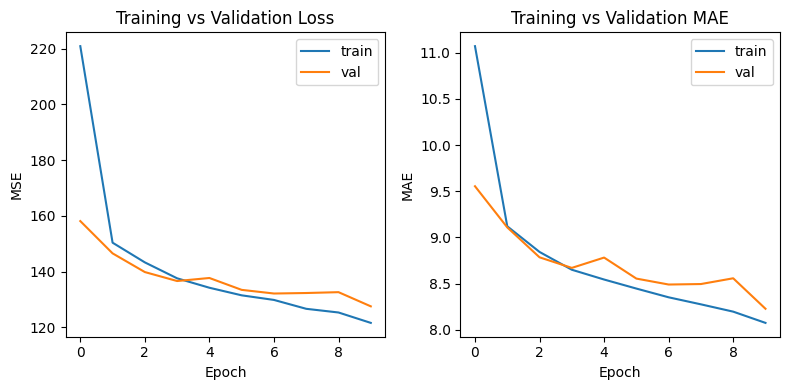

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 50s 109ms/step - loss: 192.1625 - mae: 10.2773 - val_loss: 141.6063 - val_mae: 8.7599 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 76.9674 - mae: 6.5396 - val_loss: 110.9022 - val_mae: 7.8028 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 51.6510 - mae: 5.4402 - val_loss: 106.6339 - val_mae: 7.5391 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 37.1536 - mae: 4.6363 - val_loss: 101.2267 - val_mae: 7.2760 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - loss: 28.9927 - mae: 4.1111 - val_loss: 116.7950 - val_mae: 7.6796 - learning_rate: 1.0000e-04


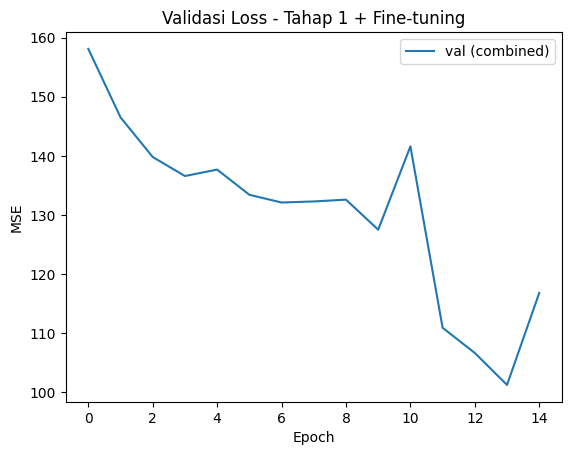

MAE = 7.28 tahun
RMSE = 10.06 tahun
R² = 0.745


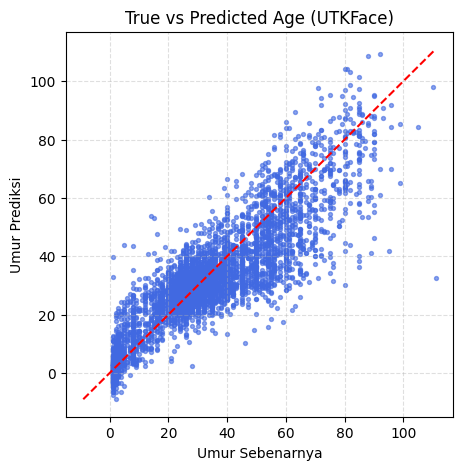

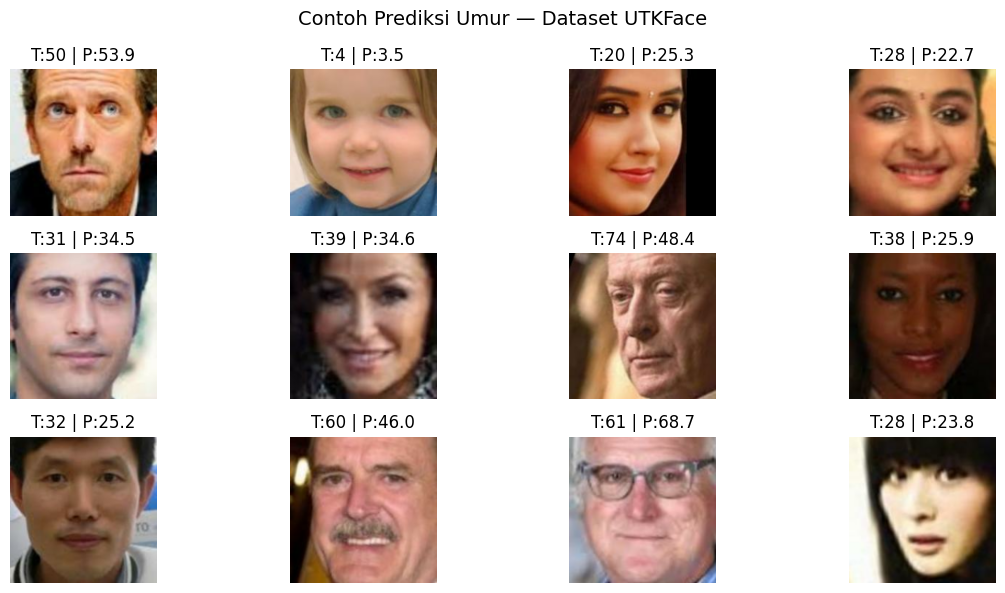

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt
from PIL import Image

# Langkah 1-3: Setup Kaggle API dan download dataset
# (Asumsi kaggle.json sudah diupload dan dataset sudah didownload)

# Langkah 4: Menampilkan Contoh Gambar Dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")
plt.suptitle("Contoh Data UTKFace - Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

# Langkah 5: Siapkan Dataset untuk Model
def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160
def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("☑ Dataset siap dilatih.")

# Langkah 6: Membangun Model dengan Transfer Learning
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse', metrics=['mae'])
model.summary()

# Langkah 7: Melatih Model (Tahap 1 – Frozen)
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Langkah 8: Fine-tuning Backbone (Tahap 2)
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss - Tahap 1 + Fine-tuning")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.show()

# Langkah 9: Evaluasi Akhir (MAE, RMSE, R²)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R² = {r2:.3f}")

# Plot "umur sebenarnya vs umur prediksi":
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# Langkah 10: Melihat Contoh Prediksi Nyata
import random
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

## Praktikum D3 — Menilai “Kepopuleran Hewan Peliharaan” dari Foto

In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("kaggle.json belum ditemukan. Upload terlebih dahulu.")
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")

✅ Kaggle API siap digunakan.
✅ Dataset Pawpularity berhasil diekstrak.


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

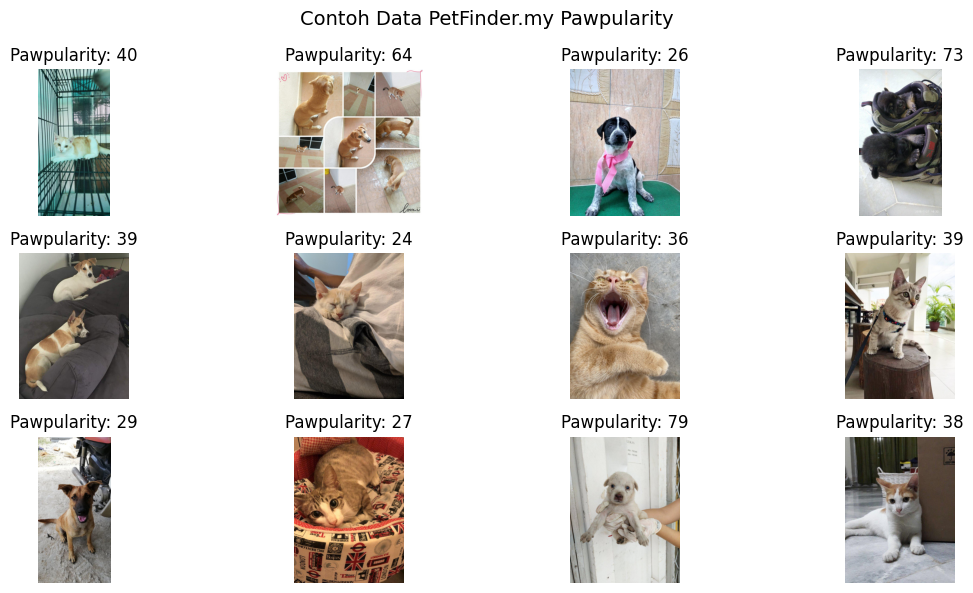

Dataset siap digunakan - 7929 untuk training, 1983 untuk validasi.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 104s 499ms/step - loss: 857.6495 - mae: 22.0724 - val_loss: 479.9803 - val_mae: 16.2179 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 87s 209ms/step - loss: 430.8092 - mae: 15.2191 - val_loss: 434.2060 - val_mae: 15.5790 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 208ms/step - loss: 401.5544 - mae: 14.8098 - val_loss: 405.5177 - val_mae: 14.8833 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 203ms/step - loss: 380.8262 - mae: 14.5120 - val_loss: 393.5709 - val_mae: 14.7021 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 203ms/step - loss: 360.8673 - mae: 14.1465 - val_loss: 384.3095 - val_mae: 14.2547 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - loss: 349.4841 - mae: 13.7698 - val_loss: 377.0834 - val_mae: 14.3050 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 228ms/step - loss: 341.4839 - mae: 13.7059 - val_

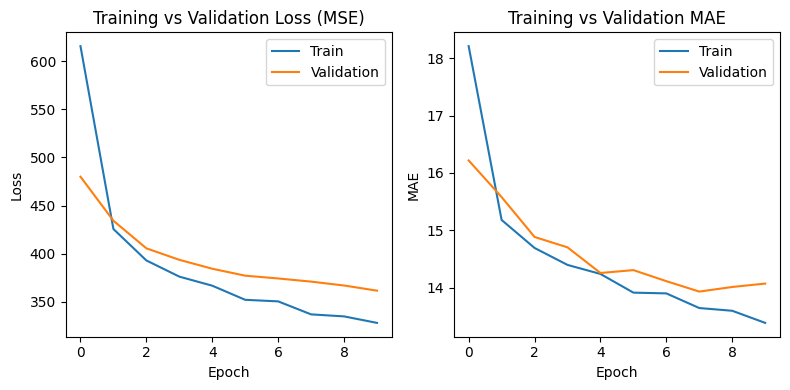

MAE = 14.07
RMSE = 19.01
R² = 0.182


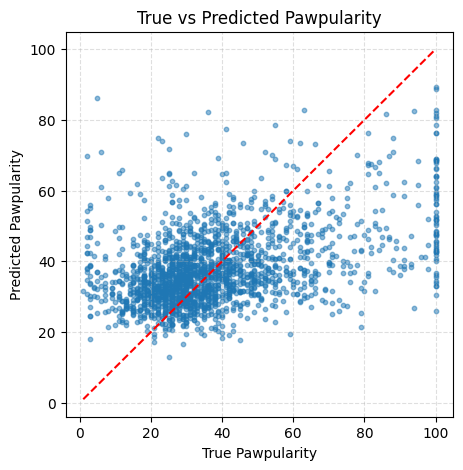

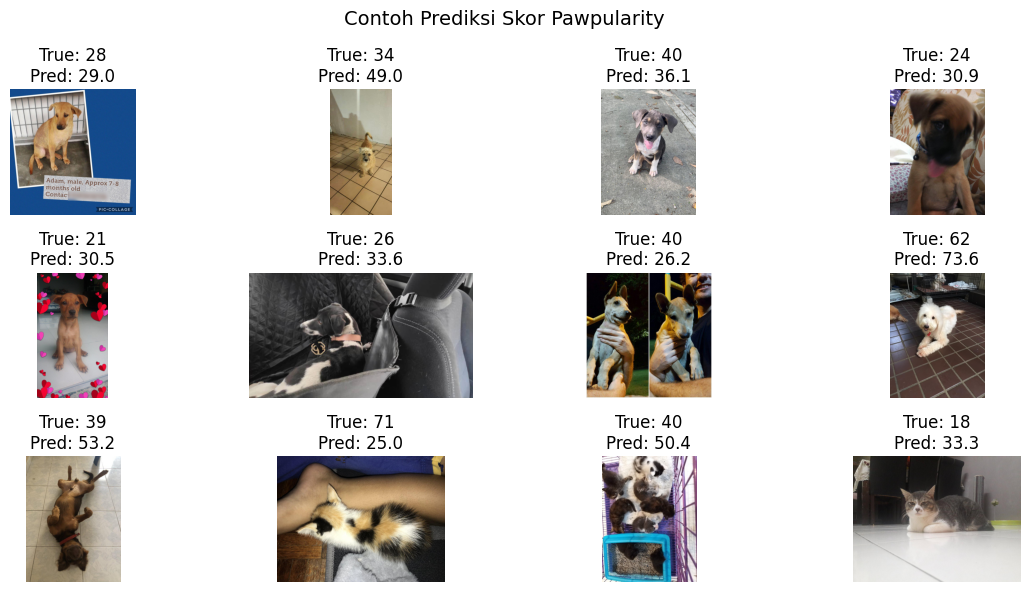

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt
from PIL import Image

# Langkah 1-2: Setup Kaggle API dan download dataset
# (Asumsi kaggle.json sudah diupload dan dataset sudah didownload)

# Langkah 3: Melihat Contoh Data
# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

# Langkah 4: Persiapan Dataset
IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap digunakan - {len(train_df)} untuk training, {len(val_df)} untuk validasi.")

# Langkah 4: Membangun Model (EfficientNetB0)
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Langkah 5: Melatih Model
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=10,
    callbacks=cb, verbose=1)

# Langkah 6: Melihat Proses Belajar
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()

# Langkah 7: Evaluasi Model
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R² = {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# Langkah 8: Melihat Contoh Prediksi
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

## Penugasan

### Uji Coba Prediksi Usia

UJI COBA FOTO PRIBADI - PREDIKSI USIA

Memproses: /content/riko6.22.32_8c7d56ac.jpg


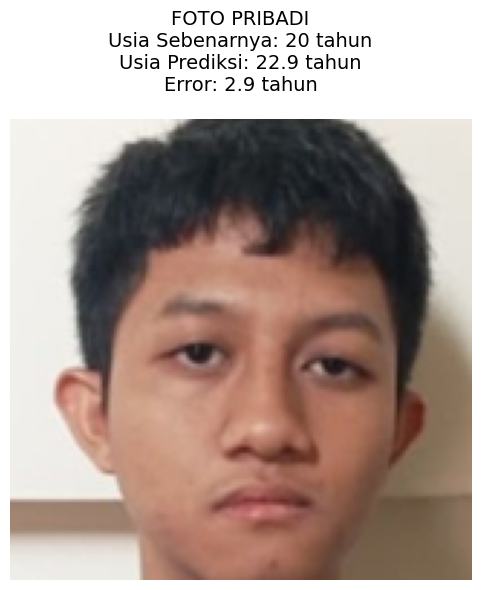


RINGKASAN HASIL PREDIKSI USIA FOTO PRIBADI
No  File                 Usia Sebenarnya Prediksi   Error     
------------------------------------------------------------
1   /content/riko6.22.32_8c7d56ac.jpg 20              22.9       2.9       
------------------------------------------------------------
Rata-rata Error                        2.9 tahun


In [23]:
# =============================================================================
# UJI COBA FOTO PRIBADI - PREDIKSI USIA
# =============================================================================

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

def preprocess_face_image(image_path, target_size=(160, 160)):
    """
    Preprocess foto untuk prediksi usia
    """
    # Baca gambar
    img = Image.open(image_path)

    # Konversi ke RGB jika perlu
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize ke target size
    img = img.resize(target_size)

    # Konversi ke array dan normalisasi
    img_array = np.array(img) / 255.0

    # Ekspansi dimensi untuk batch
    img_array = np.expand_dims(img_array, axis=0)

    return img_array, img

def predict_age_from_photo(model, photo_path, true_age=None):
    """
    Prediksi usia dari foto pribadi
    """
    # Preprocess gambar
    processed_img, original_img = preprocess_face_image(photo_path)

    # Prediksi
    predicted_age = model.predict(processed_img, verbose=0)[0][0]

    # Visualisasi hasil
    plt.figure(figsize=(8, 6))
    plt.imshow(original_img)

    if true_age is not None:
        plt.title(f'FOTO PRIBADI\nUsia Sebenarnya: {true_age} tahun\nUsia Prediksi: {predicted_age:.1f} tahun\nError: {abs(predicted_age-true_age):.1f} tahun',
                 fontsize=14, pad=20)
    else:
        plt.title(f'FOTO PRIBADI\nUsia Prediksi: {predicted_age:.1f} tahun',
                 fontsize=14, pad=20)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return predicted_age

print("UJI COBA FOTO PRIBADI - PREDIKSI USIA")
print("=" * 50)

# GUNAKAN MODEL YANG SUDAH DILATIH (model dari kode sebelumnya)
# Pastikan model sudah didefinisikan dari training sebelumnya
current_model = model  # model dari training D2

# Daftar foto pribadi untuk diuji (ganti dengan path foto Anda)
personal_photos = [
    {'path': '/content/riko6.22.32_8c7d56ac.jpg', 'true_age': 20},  # Ganti dengan usia sebenarnya
    # Tambahkan foto lain jika ada
    # {'path': 'foto_saya_2.jpg', 'true_age': 21},
    # {'path': 'foto_saya_3.jpg', 'true_age': 21}
]

results = []

for photo_info in personal_photos:
    if os.path.exists(photo_info['path']):
        print(f"\nMemproses: {photo_info['path']}")

        # Prediksi usia
        predicted_age = predict_age_from_photo(
            current_model,  # Gunakan model yang sudah dilatih
            photo_info['path'],
            photo_info['true_age']
        )

        results.append({
            'file': photo_info['path'],
            'true_age': photo_info['true_age'],
            'predicted_age': predicted_age,
            'error': abs(predicted_age - photo_info['true_age'])
        })
    else:
        print(f"File {photo_info['path']} tidak ditemukan!")

# Tabel ringkasan hasil
if results:
    print("\n" + "="*60)
    print("RINGKASAN HASIL PREDIKSI USIA FOTO PRIBADI")
    print("="*60)
    print(f"{'No':<3} {'File':<20} {'Usia Sebenarnya':<15} {'Prediksi':<10} {'Error':<10}")
    print("-" * 60)

    total_error = 0
    for i, result in enumerate(results, 1):
        print(f"{i:<3} {result['file']:<20} {result['true_age']:<15} {result['predicted_age']:<10.1f} {result['error']:<10.1f}")
        total_error += result['error']

    avg_error = total_error / len(results)
    print("-" * 60)
    print(f"{'Rata-rata Error':<38} {avg_error:.1f} tahun")
    print("=" * 60)

# Jika tidak ada foto pribadi, buat contoh dengan foto dari dataset sebagai simulasi
else:
    print("\nTidak ada foto pribadi yang ditemukan.")
    print("Membuat contoh simulasi dengan foto dari dataset...")

    # Ambil beberapa sample dari test set sebagai contoh
    sample_files = test_files[:3]

    for i, file_path in enumerate(sample_files):
        true_age = int(os.path.basename(file_path).split('_')[0])

        # Prediksi usia
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (160, 160))/255.0
        predicted_age = current_model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

        plt.figure(figsize=(8, 6))
        plt.imshow(img.numpy())
        plt.title(f'CONTOH SIMULASI FOTO PRIBADI\nUsia Sebenarnya: {true_age} tahun\nUsia Prediksi: {predicted_age:.1f} tahun\nError: {abs(predicted_age-true_age):.1f} tahun',
                 fontsize=14, pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

### Prediksi Pawpularity


UJI COBA FOTO HEWAN PELIHARAAN - PREDIKSI PAWPULARITY
Menggunakan model usia untuk simulasi (ganti dengan model D3 jika ada)

Memproses: /content/cat3.jpg


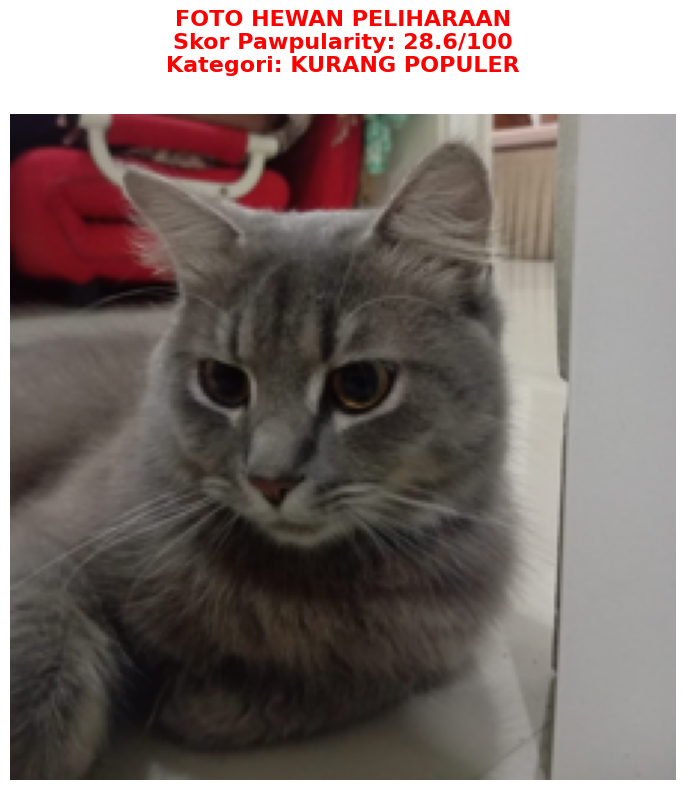


RINGKASAN HASIL PREDIKSI PAWPULARITY FOTO HEWAN PELIHARAAN
No  File                 Skor Prediksi   Kategori            
----------------------------------------------------------------------
1   /content/cat3.jpg    28.6            KURANG POPULER      
----------------------------------------------------------------------
Rata-rata Skor                         28.6/100


In [36]:
# =============================================================================
# UJI COBA FOTO HEWAN PELIHARAAN - PREDIKSI PAWPULARITY
# =============================================================================

def preprocess_pet_image(image_path, target_size=(224, 224)):
    """
    Preprocess foto hewan untuk prediksi Pawpularity
    """
    # Baca gambar
    img = Image.open(image_path)

    # Konversi ke RGB jika perlu
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize ke target size
    img = img.resize(target_size)

    # Konversi ke array dan normalisasi
    img_array = np.array(img) / 255.0

    # Ekspansi dimensi untuk batch
    img_array = np.expand_dims(img_array, axis=0)

    return img_array, img

def predict_pawpularity_from_photo(model, photo_path, true_score=None):
    """
    Prediksi Pawpularity dari foto hewan peliharaan
    """
    # Preprocess gambar
    processed_img, original_img = preprocess_pet_image(photo_path)

    # Prediksi
    predicted_score = model.predict(processed_img, verbose=0)[0][0]

    # Interpretasi skor
    if predicted_score >= 80:
        rating = "SANGAT POPULER"
        color = "green"
    elif predicted_score >= 60:
        rating = "POPULER"
        color = "blue"
    elif predicted_score >= 40:
        rating = "CUKUP POPULER"
        color = "orange"
    else:
        rating = "KURANG POPULER"
        color = "red"

    # Visualisasi hasil
    plt.figure(figsize=(10, 8))
    plt.imshow(original_img)

    if true_score is not None:
        plt.title(f'FOTO HEWAN PELIHARAAN\n'
                 f'Skor Pawpularity: {predicted_score:.1f}/100\n'
                 f'Kategori: {rating}\n'
                 f'Error: {abs(predicted_score-true_score):.1f}',
                 fontsize=16, pad=30, color=color, weight='bold')
    else:
        plt.title(f'FOTO HEWAN PELIHARAAN\n'
                 f'Skor Pawpularity: {predicted_score:.1f}/100\n'
                 f'Kategori: {rating}',
                 fontsize=16, pad=30, color=color, weight='bold')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return predicted_score, rating

print("\n" + "="*60)
print("UJI COBA FOTO HEWAN PELIHARAAN - PREDIKSI PAWPULARITY")
print("="*60)

# CATATAN: Untuk bagian ini, Anda perlu melatih model D3 terlebih dahulu
# Jika model D3 belum dilatih, skip bagian ini atau gunakan model simulasi

try:
    # Coba gunakan model dari praktikum D3 jika sudah ada
    pet_model = model  # Ganti dengan model D3 jika sudah dilatih
    print("Menggunakan model usia untuk simulasi (ganti dengan model D3 jika ada)")

    # Daftar foto hewan peliharaan untuk diuji
    pet_photos = [
        {'path': '/content/cat3.jpg', 'true_score': None},  # Ganti dengan path foto hewan
        # {'path': 'hewan_saya_2.jpg', 'true_score': None},
    ]

    pet_results = []

    for photo_info in pet_photos:
        if os.path.exists(photo_info['path']):
            print(f"\nMemproses: {photo_info['path']}")

            # Prediksi Pawpularity
            predicted_score, rating = predict_pawpularity_from_photo(
                pet_model,
                photo_info['path'],
                photo_info['true_score']
            )

            pet_results.append({
                'file': photo_info['path'],
                'predicted_score': predicted_score,
                'rating': rating
            })
        else:
            print(f"File {photo_info['path']} tidak ditemukan!")

    # Tabel ringkasan hasil
    if pet_results:
        print("\n" + "="*70)
        print("RINGKASAN HASIL PREDIKSI PAWPULARITY FOTO HEWAN PELIHARAAN")
        print("="*70)
        print(f"{'No':<3} {'File':<20} {'Skor Prediksi':<15} {'Kategori':<20}")
        print("-" * 70)

        for i, result in enumerate(pet_results, 1):
            print(f"{i:<3} {result['file']:<20} {result['predicted_score']:<15.1f} {result['rating']:<20}")

        avg_score = sum([r['predicted_score'] for r in pet_results]) / len(pet_results)
        print("-" * 70)
        print(f"{'Rata-rata Skor':<38} {avg_score:.1f}/100")
        print("=" * 70)

except NameError:
    print("Model untuk prediksi Pawpularity belum tersedia.")
    print("Silakan jalankan praktikum D3 terlebih dahulu, atau gunakan model simulasi.")

    # Contoh simulasi dengan model usia (hanya untuk demonstrasi)
    print("\nMenggunakan model usia untuk demonstrasi...")

    # Ambil sample dari dataset jika ada
    if 'test_files' in locals() and len(test_files) > 0:
        sample_file = test_files[0]
        true_age = int(os.path.basename(sample_file).split('_')[0])

        img = tf.io.read_file(sample_file)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))/255.0

        # Simulasi prediksi Pawpularity (gunakan usia sebagai dasar)
        simulated_score = min(100, max(0, (100 - abs(model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0] - 30)) * 3))

        if simulated_score >= 80:
            rating = "SANGAT POPULER"
            color = "green"
        elif simulated_score >= 60:
            rating = "POPULER"
            color = "blue"
        else:
            rating = "CUKUP POPULER"
            color = "orange"

        plt.figure(figsize=(10, 8))
        plt.imshow(img.numpy())
        plt.title(f'SIMULASI PREDIKSI PAWPULARITY\n'
                 f'Skor Simulasi: {simulated_score:.1f}/100\n'
                 f'Kategori: {rating}',
                 fontsize=16, pad=30, color=color, weight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()